In [1]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class NeuralNet:
    def __init__(self, layers):
        self.layers = layers
        self.n_in, self.n_out = layers[0].n_in, layers[-1].n_out
        
    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer.forward(out)
        return out

    def backward(self, delta):
        for layer in self.layers[::-1]:
            delta = layer.backward(delta)
        return delta
    
    def gradient_descent(self, alpha, lr):
        for layer in self.layers:
            layer.gradient_descent(alpha, lr)
            
    def reset_velocity(self):
        for layer in self.layers:
            layer.reset_velocity()
    
class MeanSquareLoss:
    def __init__(self):
        pass
    
    def forward(self, ypred, ytrue):
        d = ypred-ytrue
        n = len(d)
        self.diff_cache = d
        return 0.5 * np.sum(d*d) / n
    
    def backward(self):
        '''delta: (B, N_neuron)'''
        return self.diff_cache / n

class CrossEntropyLossFromLogits:
    def __init__(self):
        pass
    
    def forward(self, ypred, ytrue):
        n = ypred.shape[0]
        ex = np.exp(ypred-np.max(ypred))
        sum_ex = np.sum(ex, axis=1).reshape((-1,1))
        act = ex / sum_ex
        
        log_act = -np.log(act[range(n), ytrue])
        
        self.cache = (act.copy(), ytrue)
        return np.sum(log_act) / n
    
    def backward(self):
        '''delta: (B, N_neuron)'''
        act, ytrue = self.cache
        n = act.shape[0]
        act[range(n), ytrue] -= 1
        return act / n

    
class LinearLayer:
    def __init__(self, n_in, n_out, activation_func="identity"):
        self.n_in, self.n_out = n_in, n_out
        self.activation_func = activation_func
        self.W = np.random.randn(n_out, n_in) / n_in
        self.b = np.random.randn(n_out, 1) * 0.0
    
    def forward(self, x):
        net = np.matmul( x, self.W.T ) + self.b.T
        if self.activation_func == "sigmoid":
            act = 1. / (1. + np.exp(-net))
        elif self.activation_func == "relu":
            act = np.maximum(net, 0)
        else: # identity
            act = net
        self.cache = (net, act, x)
#         print("forward", net.shape, act.shape, x.shape)
        return act
    
    def backward(self, delta):
        net, act, x = self.cache
        if self.activation_func == "sigmoid":
            delta = act * (1-act) * delta
        elif self.activation_func == "relu":
            delta = (net>0) * delta
        else: # identity or softmax (cross_entropy loss)
            delta = delta
        # compute derivative
        self.dW = np.matmul(delta.T, x)
        self.db = np.sum(delta, axis=0).reshape((-1,1))
#         print("dshape", self.dW.shape, self.db.shape, delta.shape)
        
        delta = np.dot(delta, self.W)
        return delta
    
    def gradient_descent(self, alpha, lr):
        self.velW = alpha*self.velW - lr*self.dW # use momentum
        self.velb = alpha*self.velb - lr*self.db
        self.W += self.velW
        self.b += self.velb
        
    def reset_velocity(self):
        self.velW = np.zeros_like(self.W)
        self.velb = np.zeros_like(self.b)

In [146]:
# def train_net():
#     def build_net():
#         n1, n2 = 10, 1
#         li1 = LinearLayer(n1, n2)
#         net = NeuralNet([li1])
#         return net

#     net = build_net()
#     loss_func = MeanSquareLoss()
#     batch_size = 100
#     alpha, lr = 0.7, 1e-3
#     xtr = np.random.randn(batch_size, net.n_in)
#     W   = np.random.randn(net.n_out, net.n_in)
#     ytr = np.matmul(xtr, W.T)
    
#     net.reset_velocity()
#     history = []
#     for epoch in range(1, 1001):
#         out  = net.forward(xtr)
#         loss = loss_func.forward(out, ytr)
        
#         delta = loss_func.backward()
# #         print(out.shape, delta.shape)
#         net.backward(delta)
#         net.gradient_descent(alpha, lr)
        
#         history.append(loss)
#         if epoch%100 == 0:
#             print(epoch, loss)
#     return net, history
# net, history = train_net()
# plt.plot(history)

In [13]:
def train_net():
    def build_net():
        n1, n2, n3 = 64, 32, 10
        li1 = LinearLayer(n1, n2, activation_func="relu")
        li2 = LinearLayer(n2, n3, activation_func="identity")
        net = NeuralNet([li1, li2])
        return net

    net = build_net()
    loss_func = CrossEntropyLossFromLogits()
    batch_size = 100
    alpha, lr = 0.7, 1e-3
    X, y = load_digits(return_X_y=True)
    xtr, xte, ytr, yte = train_test_split(X, y, test_size=0.2)
    
    net.reset_velocity()
    history = []
    for epoch in range(1, 10001):
        out  = net.forward(xtr)
        loss = loss_func.forward(out, ytr)
        
        delta = loss_func.backward()
#         print(out.shape, delta.shape)
        net.backward(delta)
        net.gradient_descent(alpha, lr)
        
        out = net.forward(xte)
        ypred = np.argmax(out, axis=1)
        acc = (ypred==yte).sum() / len(yte)
        
        history.append(loss)
        if epoch%500 == 0:
            print(epoch, loss, acc)
    return net, history
net, history = train_net()
plt.plot(history)

500 0.28674365799326834 0.925
1000 0.15547996266943773 0.9416666666666667
1500 0.11337671106978572 0.9472222222222222
2000 0.0912502847158644 0.9555555555555556
2500 0.07697159643189451 0.9555555555555556
3000 0.0666506176317815 0.9555555555555556
3500 0.05866887473308407 0.9583333333333334
4000 0.05224250387494094 0.9583333333333334


KeyboardInterrupt: 

layer 0 act=relu
layer 1 act=relu
layer 2 act=relu
layer 3 act=identity
epoch 500 , loss 2.270, 45.00%
epoch 1000 , loss 1.880, 31.11%
epoch 1500 , loss 1.188, 61.67%
epoch 2000 , loss 0.749, 76.39%
epoch 2500 , loss 0.504, 84.44%
epoch 3000 , loss 0.386, 88.33%
epoch 3500 , loss 0.306, 91.11%
epoch 4000 , loss 0.241, 91.94%
epoch 4500 , loss 0.193, 93.33%
epoch 5000 , loss 0.161, 94.17%
epoch 5500 , loss 0.138, 94.44%
epoch 6000 , loss 0.120, 95.83%
epoch 6500 , loss 0.104, 95.83%
epoch 7000 , loss 0.092, 95.83%
epoch 7500 , loss 0.082, 96.11%
epoch 8000 , loss 0.073, 96.67%
epoch 8500 , loss 0.066, 96.67%
epoch 9000 , loss 0.060, 96.39%
epoch 9500 , loss 0.054, 96.11%
epoch 10000 , loss 0.049, 95.83%


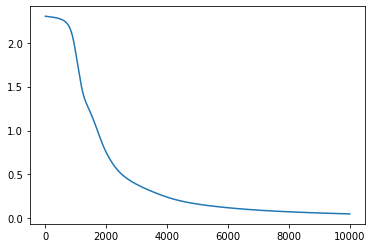

In [20]:
def train_net():
    def build_net():
        c = [64, 16, 16, 16, 10]
        layers = []
        for i in range(len(c)-1):
            act = "identity" if i >= len(c)-2 else "relu"
            print(f"layer {i} act={act}")
            layer = LinearLayer(c[i], c[i+1], activation_func=act)
            layers.append(layer)
        net = NeuralNet(layers)
        return net

    net = build_net()
    loss_func = CrossEntropyLossFromLogits()
    batch_size = 100
    alpha, lr = 0.7, 1e-3
    X, y = load_digits(return_X_y=True)
    xtr, xte, ytr, yte = train_test_split(X, y, test_size=0.2)
    
    net.reset_velocity()
    history = []
    for epoch in range(1, 10001):
        out  = net.forward(xtr)
        loss = loss_func.forward(out, ytr)
        
        delta = loss_func.backward()
#         print(out.shape, delta.shape)
        net.backward(delta)
        net.gradient_descent(alpha, lr)
        
        out = net.forward(xte)
        ypred = np.argmax(out, axis=1)
        acc = (ypred==yte).sum() / len(yte)
        
        history.append(loss)
        if epoch%500 == 0:
            print(f"epoch {epoch} , loss {loss:.3f}, {acc*100:.2f}%")
    return net, history
net, history = train_net()
plt.plot(history)

In [12]:
np.max(0, np.array([1,-1]))

TypeError: only integer scalar arrays can be converted to a scalar index